In [11]:
# !pip install openpyxl
# !pip install pandas_datareader
!pip install nsetools
# !pip install moneycontrol
# !pip install yahoo_fin

import pandas as pd
# import streamlit as st
import matplotlib.pyplot as plt
import spacy
import re
import datetime as dt

import pandas_datareader.data as web
from yahoo_fin import stock_info as si


  Using cached nsetools-1.0.11-py3-none-any.whl (9.6 kB)
  Using cached dateutils-0.6.12-py2.py3-none-any.whl (5.7 kB)


You should consider upgrading via the 'c:\users\hp\anaconda3\python.exe -m pip install --upgrade pip' command.


(0, 6)


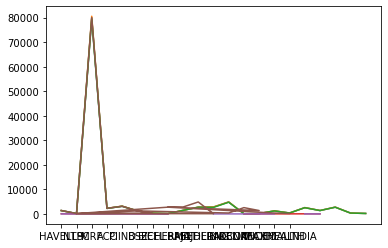

In [7]:
df=pd.read_csv('../stock_data/stock_data.csv',index_col=0)

plt.plot(df.iloc[:, 2:])
ax = plt.gca()
plt.plot(df['Symbol'],df['currentPrice'])

nlp = spacy.load("en_core_web_sm")
doc = nlp(u"Apple is looking at buying U.K. startup for $1 billion")

entities = [ent for ent in doc.ents if ent.label_ == "ORG"]

  
"""
We create a re.MatchObject and 
store it in  match_object variable, 
'()' parenthesis are used to define a 
specific group
"""
match_object = re.match(r'(\d+)',
                        '128935')
  
""" 
d in above pattern stands for numerical character
+ is used to match a consecutive set of characters 
satisfying a given condition so d+ will match a
consecutive set of numerical characters
"""
  
# generating the tuple with the 
# starting and ending index
print(match_object.span())

In [8]:
## 
# start_dt=dt.date(2021,3,1)
# end_dt=dt.date(2021,4,1)
# web.DataReader('tesla','yahoo',start_dt,end_dt)


##
si.get_live_price("aapl")

149.8000030517578

In [12]:

# importing nse from nse tools
from nsetools import Nse
 
# creating a Nse object
nse = Nse()


# getting quote of the sbin
quote = nse.get_quote('sbin')

nse.get_top_fno_gainers()
# # printing company name
# print(quote['companyName'])


[{'symbol': 'CANBK',
  'series': 'EQ',
  'openPrice': 194.65,
  'highPrice': 218.65,
  'lowPrice': 191.1,
  'ltp': 214.1,
  'previousPrice': 195.4,
  'netPrice': 9.57,
  'tradedQuantity': 72268109.0,
  'turnoverInLakhs': 151806.39,
  'lastCorpAnnouncementDate': '26-Jul-2021',
  'lastCorpAnnouncement': 'Annual General Meeting'},
 {'symbol': 'INDIGO',
  'series': 'EQ',
  'openPrice': 2000.0,
  'highPrice': 2189.7,
  'lowPrice': 1850.0,
  'ltp': 2168.0,
  'previousPrice': 1997.95,
  'netPrice': 8.51,
  'tradedQuantity': 5299099.0,
  'turnoverInLakhs': 110921.27,
  'lastCorpAnnouncementDate': '23-Aug-2021',
  'lastCorpAnnouncement': 'Annual General Meeting'},
 {'symbol': 'MCDOWELL-N',
  'series': 'EQ',
  'openPrice': 898.9,
  'highPrice': 963.4,
  'lowPrice': 881.5,
  'ltp': 951.05,
  'previousPrice': 892.55,
  'netPrice': 6.55,
  'tradedQuantity': 9686157.0,
  'turnoverInLakhs': 90764.13,
  'lastCorpAnnouncementDate': '13-Aug-2019',
  'lastCorpAnnouncement': 'Annual General Meeting'},
 {'